# Download + unzip

*Structure:*
- 70 subjects
- Each subject folder contains:
- *_rr_mni_flair.nii → MRI FLAIR image
- *_rr_mni_lesion.nii → lesion mask
- Total: 70 FLAIR + 70 masks = 140 files

*Image Properties:*
- Shape: (181, 217, 181) (MNI space)
- Single modality: FLAIR only
- Intensity range roughly 0–280 (MRI, not HU)

*Mask Properties*
- Shape matches image
- Labels:

    0 = background
  
    1–4 = lesion subtypes

In [ ]:
# ====== Download from Google Drive and unzip ======
import os, re, subprocess, zipfile, shutil
from pathlib import Path

GDRIVE_URL = "****"
OUT_DIR = Path("/kaggle/working/ms_dataset")
ZIP_PATH = OUT_DIR / "dataset.zip"
EXTRACT_DIR = OUT_DIR / "extracted"

OUT_DIR.mkdir(parents=True, exist_ok=True)
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

def extract_gdrive_file_id(url: str) -> str:
    # supports /file/d/<id>/view and also id=<id>
    m = re.search(r"/file/d/([^/]+)/", url)
    if m:
        return m.group(1)
    m = re.search(r"[?&]id=([^&]+)", url)
    if m:
        return m.group(1)
    raise ValueError("Could not extract file id from URL")

file_id = extract_gdrive_file_id(GDRIVE_URL)
print("Google Drive file id:", file_id)

# Install gdown
subprocess.check_call(["pip", "-q", "install", "gdown"])

import gdown

# Download
print("Downloading...")
gdown.download(id=file_id, output=str(ZIP_PATH), quiet=False)

print("Downloaded ZIP:", ZIP_PATH, "size:", ZIP_PATH.stat().st_size, "bytes")

# Unzip (overwrite if needed)
print("Unzipping...")
# clean extract dir if rerun
if EXTRACT_DIR.exists():
    shutil.rmtree(EXTRACT_DIR)
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    z.extractall(EXTRACT_DIR)

print("Extracted to:", EXTRACT_DIR)

if os.path.exists("/kaggle/working/ms_dataset"):
    os.remove("/kaggle/working/ms_dataset/dataset.zip")

old_path = "/kaggle/working/ms_dataset/extracted/Challenge 2 - MS/30-"
new_path = "/kaggle/working/ms_dataset/extracted/Challenge 2 - MS/30"

if os.path.exists(old_path):
    os.rename(old_path, new_path)
    print("Renamed successfully.")
else:
    print("Source path does not exist.")

old_path = "/kaggle/working/ms_dataset/extracted/Challenge 2 - MS/43-"
new_path = "/kaggle/working/ms_dataset/extracted/Challenge 2 - MS/43"

if os.path.exists(old_path):
    os.rename(old_path, new_path)
    print("Renamed successfully.")
else:
    print("Source path does not exist.")

# Investigate the dataset structure

In [2]:
# ====== Inspect folder tree and file counts ======
import os
from collections import Counter
from pathlib import Path

root = Path("/kaggle/working/ms_dataset/extracted")

all_files = [p for p in root.rglob("*") if p.is_file()]
print("Total files:", len(all_files))

# show top-level structure
print("\nTop-level items:")
for p in sorted(root.iterdir()):
    print(" -", p.name, "(dir)" if p.is_dir() else "(file)")

# count extensions
exts = Counter([p.suffix.lower() for p in all_files])
print("\nExtensions:")
for k,v in exts.most_common():
    print(f"{k:10s} {v}")

# list a few sample files
print("\nSample files:")
for p in all_files[:25]:
    print(" -", p.relative_to(root))

Total files: 140

Top-level items:
 - Challenge 2 - MS (dir)

Extensions:
.nii       140

Sample files:
 - Challenge 2 - MS/50/50_rr_mni_flair.nii
 - Challenge 2 - MS/50/50_rr_mni_lesion.nii
 - Challenge 2 - MS/13/13_rr_mni_flair.nii
 - Challenge 2 - MS/13/13_rr_mni_lesion.nii
 - Challenge 2 - MS/27/27_rr_mni_flair.nii
 - Challenge 2 - MS/27/27_rr_mni_lesion.nii
 - Challenge 2 - MS/33/33_rr_mni_flair.nii
 - Challenge 2 - MS/33/33_rr_mni_lesion.nii
 - Challenge 2 - MS/01/1_rr_mni_lesion.nii
 - Challenge 2 - MS/01/1_rr_mni_flair.nii
 - Challenge 2 - MS/22/22_rr_mni_lesion.nii
 - Challenge 2 - MS/22/22_rr_mni_flair.nii
 - Challenge 2 - MS/41/41_rr_mni_flair.nii
 - Challenge 2 - MS/41/41_rr_mni_lesion.nii
 - Challenge 2 - MS/44/44_rr_mni_lesion.nii
 - Challenge 2 - MS/44/44_rr_mni_flair.nii
 - Challenge 2 - MS/61/61_rr_mni_flair.nii
 - Challenge 2 - MS/61/61_rr_mni_lesion.nii
 - Challenge 2 - MS/66/66_rr_mni_flair.nii
 - Challenge 2 - MS/66/66_rr_mni_lesion.nii
 - Challenge 2 - MS/68/68_rr

# Find NIfTI images/masks + check shapes/mask labels

In [3]:
# ====== Scan NIfTI files, infer "image" vs "mask", report shapes and mask labels ======
import re
import nibabel as nib
import numpy as np
from pathlib import Path
from collections import defaultdict

root = Path("/kaggle/working/ms_dataset/extracted")
nii_files = sorted(list(root.rglob("*.nii")) + list(root.rglob("*.nii.gz")))
print("NIfTI files found:", len(nii_files))

def is_mask_path(p: Path) -> bool:
    s = str(p).lower()
    return any(k in s for k in ["mask", "seg", "label", "lesion"])

def safe_load_nii(path: Path):
    nii = nib.load(str(path))
    data = nii.get_fdata(dtype=np.float32)
    return nii, data

# Separate candidates
mask_files = [p for p in nii_files if is_mask_path(p)]
img_files  = [p for p in nii_files if not is_mask_path(p)]

print("Mask-like NIfTI:", len(mask_files))
print("Image-like NIfTI:", len(img_files))

# Peek a few shapes
def peek_shapes(paths, n=5):
    for p in paths[:n]:
        _, d = safe_load_nii(p)
        print(p.name, "shape:", d.shape, "min/max:", float(np.min(d)), float(np.max(d)))

print("\n--- Example image shapes ---")
peek_shapes(img_files, n=5)

print("\n--- Example mask shapes + unique labels (sampled) ---")
for p in mask_files[:5]:
    _, d = safe_load_nii(p)
    # for masks we want integer-ish uniques; do safe rounding
    u = np.unique(np.round(d).astype(np.int16))
    print(p.name, "shape:", d.shape, "unique:", u[:50], ("... (many)" if len(u)>50 else ""))

NIfTI files found: 140
Mask-like NIfTI: 70
Image-like NIfTI: 70

--- Example image shapes ---
1_rr_mni_flair.nii shape: (181, 217, 181) min/max: 0.0 221.03929138183594
2_rr_mni_flair.nii shape: (181, 217, 181) min/max: 0.0 229.19485473632812
3_rr_mni_flair.nii shape: (181, 217, 181) min/max: 0.0 238.99046325683594
4_rr_mni_flair.nii shape: (181, 217, 181) min/max: 0.0 229.15106201171875
5_rr_mni_flair.nii shape: (181, 217, 181) min/max: 0.0 284.2813415527344

--- Example mask shapes + unique labels (sampled) ---
1_rr_mni_lesion.nii shape: (181, 217, 181) unique: [0 1 2 3] 
2_rr_mni_lesion.nii shape: (181, 217, 181) unique: [0 1 2 3 4] 
3_rr_mni_lesion.nii shape: (181, 217, 181) unique: [0 1 2 3 4] 
4_rr_mni_lesion.nii shape: (181, 217, 181) unique: [0 1 2 3 4] 
5_rr_mni_lesion.nii shape: (181, 217, 181) unique: [0 1 2 3 4] 


In [8]:
# ====== Attempt to pair images and masks by stem tokens ======
from pathlib import Path
import re

def norm_key(p: Path) -> str:
    # remove common words and extensions to form a pairing key
    name = p.name.lower()
    name = re.sub(r"\.nii(\.gz)?$", "", name)
    name = re.sub(r"(mask|seg|label|lesion|gt|groundtruth|truth)", "", name)
    name = re.sub(r"__+", "_", name).strip("_- ")
    return name

img_map = {}
for p in img_files:
    k = norm_key(p)
    img_map.setdefault(k, []).append(p)

msk_map = {}
for p in mask_files:
    k = norm_key(p)
    msk_map.setdefault(k, []).append(p)

keys = sorted(list(set(img_map.keys()) & set(msk_map.keys())))
print("Potential paired keys:", len(keys))

# show some pairs
for k in keys[:20]:
    print("\nKEY:", k)
    print("  images:", [x.name for x in img_map[k][:3]])
    print("  masks :", [x.name for x in msk_map[k][:3]])

Potential paired keys: 0


Using image: /kaggle/working/ms_dataset/extracted/Challenge 2 - MS/01/1_rr_mni_flair.nii
Using mask : /kaggle/working/ms_dataset/extracted/Challenge 2 - MS/01/1_rr_mni_lesion.nii
Image shape: (181, 217, 181) Mask shape: (181, 217, 181)
Lesion slices: 45


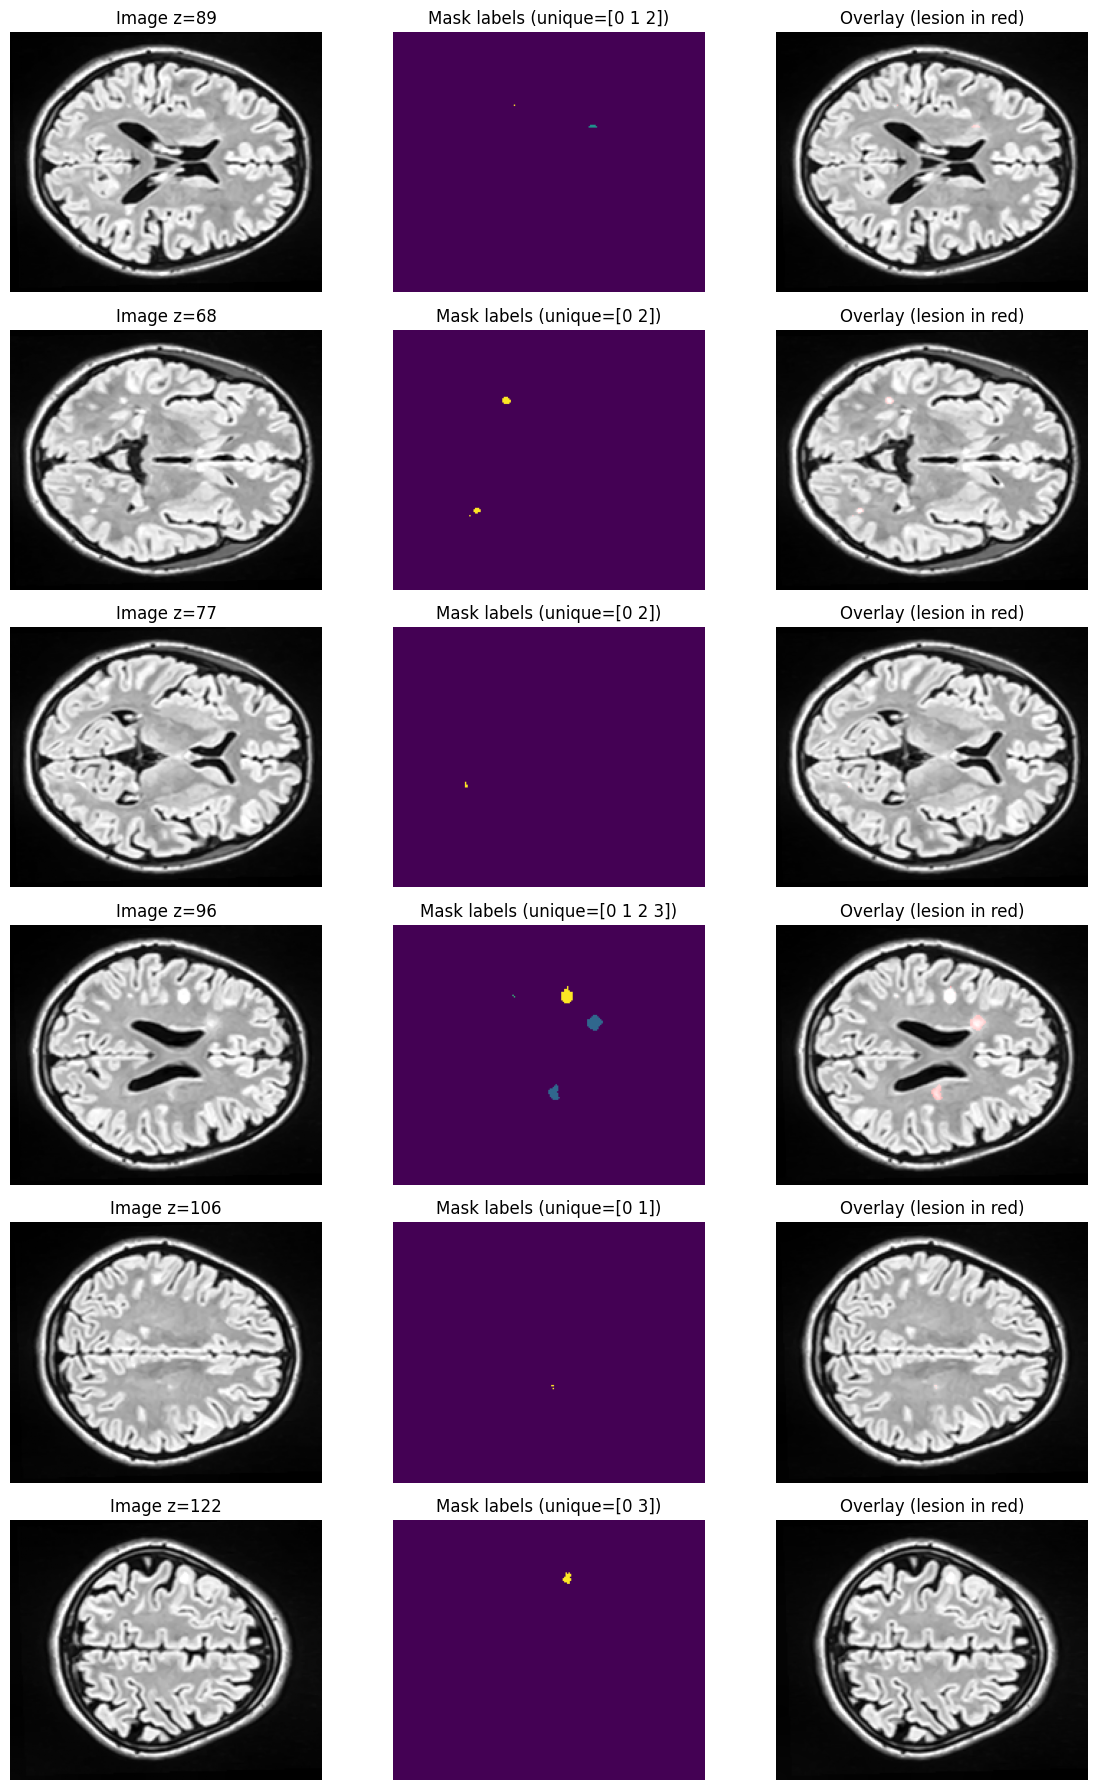

In [9]:
# ====== Visualize axial slices with lesions (overlay) ======
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from pathlib import Path
import random

# pick one paired subject if available; otherwise pick any image+mask
if len(keys) > 0:
    k = keys[0]
    img_path = img_map[k][0]
    msk_path = msk_map[k][0]
else:
    # fallback: random image and random mask
    img_path = img_files[0] if len(img_files) else None
    msk_path = mask_files[0] if len(mask_files) else None

print("Using image:", img_path)
print("Using mask :", msk_path)

img_nii = nib.load(str(img_path))
msk_nii = nib.load(str(msk_path))
img = img_nii.get_fdata(dtype=np.float32)
msk = msk_nii.get_fdata(dtype=np.float32)

print("Image shape:", img.shape, "Mask shape:", msk.shape)

# Find slices that contain lesion labels > 0
# (binary lesion: >0, but labels 1..4 may exist)
msk_int = np.round(msk).astype(np.int16)
lesion_slices = np.where(msk_int.reshape(-1, msk_int.shape[-1]).sum(axis=0) > 0)[0] if msk_int.ndim == 3 else np.array([])
print("Lesion slices:", len(lesion_slices))

def show_slices(n=6):
    if msk_int.ndim != 3:
        print("Mask is not 3D; adjust visualization code for your data.")
        return
    if len(lesion_slices) == 0:
        zs = [img.shape[2]//2]
    else:
        zs = random.sample(list(lesion_slices), k=min(n, len(lesion_slices)))

    plt.figure(figsize=(12, 3*len(zs)))
    for i, z in enumerate(zs):
        im = img[:, :, z]
        ma = msk_int[:, :, z]

        # normalize image for display
        im_disp = im.copy()
        if np.std(im_disp) > 1e-6:
            im_disp = (im_disp - np.percentile(im_disp, 1)) / (np.percentile(im_disp, 99) - np.percentile(im_disp, 1) + 1e-8)
        im_disp = np.clip(im_disp, 0, 1)

        overlay = np.stack([im_disp, im_disp, im_disp], axis=-1)
        # red = any lesion
        overlay[..., 0] = np.clip(overlay[..., 0] + 0.7*(ma > 0), 0, 1)

        ax = plt.subplot(len(zs), 3, 3*i + 1)
        ax.imshow(im_disp, cmap="gray"); ax.set_title(f"Image z={z}"); ax.axis("off")

        ax = plt.subplot(len(zs), 3, 3*i + 2)
        ax.imshow(ma, cmap="viridis"); ax.set_title(f"Mask labels (unique={np.unique(ma)})"); ax.axis("off")

        ax = plt.subplot(len(zs), 3, 3*i + 3)
        ax.imshow(overlay); ax.set_title("Overlay (lesion in red)"); ax.axis("off")

    plt.tight_layout()
    plt.show()

show_slices(n=6)

# Data Preparation and Model Definition

In [29]:
import os, re, glob, random, time, shutil
from dataclasses import dataclass
from typing import List

import numpy as np
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import nibabel as nib

# -----------------------
# 1) Config (MS Lesion 2D binary segmentation)
# -----------------------
@dataclass
class CFG:
    DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"

    # MS dataset root (extracted zip)
    BASE_PATH: str = "/kaggle/working/ms_dataset/extracted/Challenge 2 - MS"

    # MS Lesion segmentation cache
    CACHE_DIR: str = "/kaggle/working/ms_cache_Lesion"

    IMG_SIZE: int = 256

    VAL_SPLIT: float = 0.2
    SEED: int = 42

    # Keep some negative slices (no lesion => mask==0)
    KEEP_NEGATIVE_PROB: float = 0.05
    ONLY_LESION_SLICES: bool = True  # if True, keep only positive slices + sampled negatives

    BATCH_SIZE: int = 16
    NUM_WORKERS: int = 2
    PIN_MEMORY: bool = True

cfg = CFG()
random.seed(cfg.SEED)
np.random.seed(cfg.SEED)
torch.manual_seed(cfg.SEED)

os.makedirs(cfg.CACHE_DIR, exist_ok=True)

# -----------------------
# 2) Pairing helpers (MS subject folders)
# -----------------------
def extract_subject_id(path: str) -> int:
    s = path.replace("\\", "/")
    m = re.search(r"/(\d+)/(\d+)_rr_mni_(?:flair|lesion)\.nii$", s)
    if not m:
        raise ValueError(f"Cannot parse subject id from {path}")
    # folder id and filename id should match; return filename id
    return int(m.group(2))

ms_flair_paths = sorted(glob.glob(os.path.join(cfg.BASE_PATH, "*", "*_rr_mni_flair.nii")))
ms_lesion_paths = sorted(glob.glob(os.path.join(cfg.BASE_PATH, "*", "*_rr_mni_lesion.nii")))

flair_map = {extract_subject_id(p): p for p in ms_flair_paths}
lesion_map = {extract_subject_id(p): p for p in ms_lesion_paths}

subject_ids = sorted(list(set(flair_map.keys()) & set(lesion_map.keys())))
assert len(subject_ids) > 0, "No matched FLAIR/lesion pairs found."

print(f"Matched subjects: {len(subject_ids)}")

train_ids, val_ids = train_test_split(subject_ids, test_size=cfg.VAL_SPLIT, random_state=cfg.SEED)
train_ids = sorted(train_ids)
val_ids = sorted(val_ids)
print(f"Train subjects: {len(train_ids)} | Val subjects: {len(val_ids)}")

# -----------------------
# 3) Preprocess helpers (MRI FLAIR)
# -----------------------
def resize2d(img2d: np.ndarray, size: int, is_mask: bool) -> np.ndarray:
    interp = cv2.INTER_NEAREST if is_mask else cv2.INTER_AREA
    return cv2.resize(img2d, (size, size), interpolation=interp)

def cache_paths(split: str):
    img_dir = os.path.join(cfg.CACHE_DIR, split, "images")
    msk_dir = os.path.join(cfg.CACHE_DIR, split, "masks")
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(msk_dir, exist_ok=True)
    return img_dir, msk_dir

def create_multi_channel_image(flair_slice: np.ndarray) -> np.ndarray:
    """
    Minimal-change replacement for CT-based channels:
    - ch1: robust normalized FLAIR
    - ch2: CLAHE-enhanced version of ch1 (local contrast)
    - ch3: gradient magnitude of ch1
    Output: [H,W,3] float32 in [0,1]
    """
    x = flair_slice.astype(np.float32, copy=False)

    # robust normalize (1..99)
    p1, p99 = np.percentile(x, (1, 99))
    base = np.clip(x, p1, p99)
    base = (base - base.min()) / (base.max() - base.min() + 1e-8)
    base = np.ascontiguousarray(base, dtype=np.float32)

    ch1 = base

    # CLAHE on uint8 then back to float [0,1]
    base_u8 = (base * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    ch2 = clahe.apply(base_u8).astype(np.float32) / 255.0

    sobelx = cv2.Sobel(base, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
    sobely = cv2.Sobel(base, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3)
    grad = cv2.magnitude(sobelx, sobely)
    ch3 = grad / (grad.max() + 1e-8)

    out = np.stack([ch1, ch2, ch3], axis=-1).astype(np.float32)
    out = np.clip(out, 0, 1)
    return out

# -----------------------
# 5) Dataset
# -----------------------
class NPYSliceDataset(Dataset):
    def __init__(self, cache_root: str, split: str, augment: bool = False, show_scan_progress: bool = True):
        self.img_dir = os.path.join(cache_root, split, "images")
        self.msk_dir = os.path.join(cache_root, split, "masks")

        img_glob = os.path.join(self.img_dir, "*.npy")
        img_paths = glob.glob(img_glob)

        if show_scan_progress:
            self.img_paths = []
            for p in tqdm(sorted(img_paths), desc=f"Indexing {split} .npy slices"):
                self.img_paths.append(p)
        else:
            self.img_paths = sorted(img_paths)

        assert len(self.img_paths) > 0, f"No cached images found in {self.img_dir}"
        self.augment = augment

    def __len__(self):
        return len(self.img_paths)

    def _augment_pair(self, img, msk):
        if random.random() < 0.5:
            img = np.fliplr(img).copy()
            msk = np.fliplr(msk).copy()
        if random.random() < 0.5:
            img = np.flipud(img).copy()
            msk = np.flipud(msk).copy()
        return img, msk

    # def __getitem__(self, idx):
    #     img_path = self.img_paths[idx]
    #     stem = os.path.basename(img_path)
    #     msk_path = os.path.join(self.msk_dir, stem)

    #     # img = np.load(img_path).astype(np.float32)  # [H,W,3]
    #     # msk = np.load(msk_path).astype(np.float32)  # [H,W]

    #     img = np.ascontiguousarray(img, dtype=np.float32)
    #     msk = np.ascontiguousarray(msk, dtype=np.float32)
        
    #     img_t = torch.from_numpy(img).permute(2,0,1).contiguous()
    #     msk_t = torch.from_numpy(msk).unsqueeze(0).contiguous()
    #     if self.augment:
    #         img, msk = self._augment_pair(img, msk)

    #     # img_t = torch.from_numpy(img).permute(2, 0, 1)  # [3,H,W]
    #     # msk_t = torch.from_numpy(msk).unsqueeze(0)      # [1,H,W]
    #     img_t = torch.from_numpy(img).permute(2, 0, 1).contiguous()  # [3,H,W]
    #     msk_t = torch.from_numpy(msk).unsqueeze(0).contiguous()      # [1,H,W]
    #     return img_t, msk_t
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        stem = os.path.basename(img_path)
        msk_path = os.path.join(self.msk_dir, stem)
    
        # ALWAYS load first
        img = np.load(img_path).astype(np.float32)  # [H,W,3]
        msk = np.load(msk_path).astype(np.float32)  # [H,W]
    
        # optional augmentation
        if self.augment:
            img, msk = self._augment_pair(img, msk)
    
        # make contiguous for torch
        img = np.ascontiguousarray(img, dtype=np.float32)
        msk = np.ascontiguousarray(msk, dtype=np.float32)
    
        # HWC -> CHW
        img_t = torch.from_numpy(img).permute(2, 0, 1).contiguous()  # [3,H,W]
        msk_t = torch.from_numpy(msk).unsqueeze(0).contiguous()      # [1,H,W]
        return img_t, msk_t

# ============================================================
# 6) Base U-Net 
# ============================================================
class DoubleConvNoBN(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=True),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNetBase(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base=64):
        super().__init__()
        self.enc1 = DoubleConvNoBN(in_channels, base)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConvNoBN(base, base*2)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConvNoBN(base*2, base*4)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = DoubleConvNoBN(base*4, base*8)
        self.pool4 = nn.MaxPool2d(2)

        self.bot = DoubleConvNoBN(base*8, base*16)

        self.up4 = nn.ConvTranspose2d(base*16, base*8, 2, stride=2)
        self.dec4 = DoubleConvNoBN(base*16, base*8)

        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.dec3 = DoubleConvNoBN(base*8, base*4)

        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec2 = DoubleConvNoBN(base*4, base*2)

        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec1 = DoubleConvNoBN(base*2, base)

        self.outc = nn.Conv2d(base, out_channels, 1)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))
        x4 = self.enc4(self.pool3(x3))
        xb = self.bot(self.pool4(x4))

        u4 = self.up4(xb)
        d4 = self.dec4(torch.cat([u4, x4], dim=1))

        u3 = self.up3(d4)
        d3 = self.dec3(torch.cat([u3, x3], dim=1))

        u2 = self.up2(d3)
        d2 = self.dec2(torch.cat([u2, x2], dim=1))

        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, x1], dim=1))

        return self.outc(d1)

# ============================================================
# 7) Loss + Metrics
# ============================================================
def dice_loss_from_logits(logits, y, eps=1e-6):
    p = torch.sigmoid(logits)
    num = 2*(p*y).sum(dim=(2,3)) + eps
    den = (p+y).sum(dim=(2,3)) + eps
    return 1 - (num/den).mean()

class BCEDice(nn.Module):
    def __init__(self, pos_weight=1.0, bce_weight=0.5):
        super().__init__()
        self.register_buffer("pw", torch.tensor([pos_weight], dtype=torch.float32))
        self.bce_weight = bce_weight
    def forward(self, logits, y):
        bce = F.binary_cross_entropy_with_logits(logits, y, pos_weight=self.pw)
        d   = dice_loss_from_logits(logits, y)
        return self.bce_weight*bce + (1-self.bce_weight)*d

@torch.no_grad()
def estimate_pos_weight(loader, device, max_batches=40):
    pos = 0.0
    neg = 0.0
    for i, (x, y) in enumerate(loader):
        if i >= max_batches: break
        y = y.to(device)
        pos += y.sum().item()
        neg += (1 - y).sum().item()
    return 1.0 if pos < 1 else float(neg / pos)

@torch.no_grad()
def metrics_from_logits(logits, y, thr=0.5, eps=1e-8):
    p = (torch.sigmoid(logits) > thr).float()
    tp = (p*y).sum().item()
    tn = ((1-p)*(1-y)).sum().item()
    fp = (p*(1-y)).sum().item()
    fn = ((1-p)*y).sum().item()
    dice = (2*tp)/(2*tp+fp+fn+eps)
    iou  = tp/(tp+fp+fn+eps)
    acc  = (tp+tn)/(tp+tn+fp+fn+eps)
    sens = tp/(tp+fn+eps)
    spec = tn/(tn+fp+eps)
    return {"dice":dice,"iou":iou,"acc":acc,"sens":sens,"spec":spec}

@torch.no_grad()
def evaluate(model, loader, loss_fn, device):
    model.eval()
    agg = {"loss":0.0,"dice":0.0,"iou":0.0,"acc":0.0,"sens":0.0,"spec":0.0}
    n = 0
    loop = tqdm(loader, desc="Validation", leave=False)
    for x, y in loop:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        loss = loss_fn(logits, y).item()
        m = metrics_from_logits(logits, y)
        bs = x.size(0)
        agg["loss"] += loss*bs
        for k in m: agg[k] += m[k]*bs
        n += bs
        loop.set_postfix(loss=f"{loss:.4f}", dice=f"{m['dice']:.3f}", acc=f"{m['acc']:.3f}")
    for k in agg: agg[k] /= max(n,1)
    return agg

def train_one_epoch(model, loader, opt, loss_fn, device):
    model.train()
    running = 0.0
    n = 0
    loop = tqdm(loader, desc="Training", leave=False)
    for x, y in loop:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        opt.zero_grad(set_to_none=True)
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        opt.step()

        bs = x.size(0)
        running += loss.item()*bs
        n += bs

        m = metrics_from_logits(logits.detach(), y.detach())
        loop.set_postfix(loss=f"{loss.item():.4f}", dice=f"{m['dice']:.3f}", acc=f"{m['acc']:.3f}")

    return running/max(n,1)

Matched subjects: 70
Train subjects: 56 | Val subjects: 14


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import random

class HistoryLogger:
    def __init__(self, tag: str, out_dir="/kaggle/working"):
        self.tag = tag
        self.out_dir = out_dir
        self.rows = []

    def add(self, epoch: int, train_loss: float, val_dict: dict, lr: float, sec: float):
        row = {
            "epoch": epoch,
            "train_loss": float(train_loss),
            "val_loss": float(val_dict["loss"]),
            "dice": float(val_dict.get("dice", np.nan)),
            "iou": float(val_dict.get("iou", np.nan)),
            "acc": float(val_dict.get("acc", np.nan)),
            "sens": float(val_dict.get("sens", np.nan)),
            "spec": float(val_dict.get("spec", np.nan)),
            "lr": float(lr),
            "sec": float(sec),
        }
        self.rows.append(row)

    def to_df(self):
        return pd.DataFrame(self.rows)

    def save_csv(self):
        df = self.to_df()
        path = f"{self.out_dir}/history_{self.tag}.csv"
        df.to_csv(path, index=False)
        print(f"saved {path}")
        return path

    def plot(self):
        df = self.to_df()
        if len(df) == 0:
            print("No history to plot.")
            return

        plt.figure()
        plt.plot(df["epoch"], df["train_loss"], label="train_loss")
        plt.plot(df["epoch"], df["val_loss"], label="val_loss")
        plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{self.tag} Loss"); plt.legend()
        plt.grid(True, alpha=0.3)
        loss_path = f"{self.out_dir}/plot_{self.tag}_loss.png"
        plt.savefig(loss_path, dpi=150, bbox_inches="tight")
        plt.show()
        print(f"saved {loss_path}")

        if "dice" in df.columns:
            plt.figure()
            plt.plot(df["epoch"], df["dice"], label="dice")
            if "iou" in df.columns:
                plt.plot(df["epoch"], df["iou"], label="iou")
            plt.xlabel("Epoch"); plt.ylabel("Score"); plt.title(f"{self.tag} Dice/IoU"); plt.legend()
            plt.grid(True, alpha=0.3)
            met_path = f"{self.out_dir}/plot_{self.tag}_metrics.png"
            plt.savefig(met_path, dpi=150, bbox_inches="tight")
            plt.show()
            print(f"saved {met_path}")

        if "acc" in df.columns:
            plt.figure()
            plt.plot(df["epoch"], df["acc"], label="acc")
            if "sens" in df.columns:
                plt.plot(df["epoch"], df["sens"], label="sens")
            if "spec" in df.columns:
                plt.plot(df["epoch"], df["spec"], label="spec")
            plt.xlabel("Epoch"); plt.ylabel("Score"); plt.title(f"{self.tag} Acc/Sens/Spec"); plt.legend()
            plt.grid(True, alpha=0.3)
            cls_path = f"{self.out_dir}/plot_{self.tag}_clsmetrics.png"
            plt.savefig(cls_path, dpi=150, bbox_inches="tight")
            plt.show()
            print(f"saved {cls_path}")


@torch.no_grad()
def visualize_predictions(model, loader, device, n=6, thr=0.5, title="preds"):
    model.eval()
    batch = next(iter(loader))
    x, y = batch
    x = x.to(device)
    y = y.to(device)

    logits = model(x)
    prob = torch.sigmoid(logits)
    pred = (prob > thr).float()

    n = min(n, x.shape[0])
    idxs = random.sample(range(x.shape[0]), n)

    plt.figure(figsize=(12, 2*n))
    for i, idx in enumerate(idxs):
        img = x[idx, 0].detach().cpu().numpy()  # show channel 0
        gt  = y[idx, 0].detach().cpu().numpy()
        pr  = pred[idx, 0].detach().cpu().numpy()

        overlay = np.stack([img, img, img], axis=-1)
        overlay[..., 0] = np.clip(overlay[..., 0] + 0.6*pr, 0, 1)
        overlay[..., 1] = np.clip(overlay[..., 1] + 0.6*gt, 0, 1)

        ax = plt.subplot(n, 3, 3*i + 1)
        ax.imshow(img, cmap="gray"); ax.set_title("FLAIR (ch0)"); ax.axis("off")
        ax = plt.subplot(n, 3, 3*i + 2)
        ax.imshow(gt, cmap="gray"); ax.set_title("lesion gt (binary)"); ax.axis("off")
        ax = plt.subplot(n, 3, 3*i + 3)
        ax.imshow(overlay); ax.set_title("overlay (pred red, gt green)"); ax.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    out_path = f"/kaggle/working/{title}.png"
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"saved {out_path}")

# ============================================================
# Cache builder (minimal change, MS lesion instead of LiverTumor)
# ============================================================
def pad_to_square(img, is_mask=False):
    h, w = img.shape[:2]
    if h == w:
        return img

    size = max(h, w)
    pad_h = size - h
    pad_w = size - w

    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left

    border_type = cv2.BORDER_CONSTANT
    value = 0

    return cv2.copyMakeBorder(
        img,
        top, bottom, left, right,
        borderType=border_type,
        value=value
    )
def build_cache_MSLesion_for_ids(subject_ids, split: str):
    img_dir, msk_dir = cache_paths(split)
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(msk_dir, exist_ok=True)

    print(f"[{split}] Building MSLesion cache ...")
    kept_pos = 0
    kept_neg = 0

    keep_neg_prob = cfg.KEEP_NEGATIVE_PROB if split == "train" else 0.0

    for sid in tqdm(subject_ids, desc=f"Building {split} MSLesion cache (subjects)"):
        flair = nib.load(flair_map[sid]).get_fdata(dtype=np.float32)   # (H,W,Z)
        lesion = nib.load(lesion_map[sid]).get_fdata(dtype=np.float32) # (H,W,Z)
        Z = flair.shape[2]
        # Y = flair.shape[1]

        for z in range(Z):
        # for y in range(Y):
            m = lesion[:, :, z]
            # m = lesion[:, y, :]

            # binary lesion: any label > 0
            fg = (m > 0).astype(np.float32)

            is_positive = fg.sum() >= 20

            if cfg.ONLY_LESION_SLICES:
                if not is_positive:
                    if random.random() > keep_neg_prob:
                        continue

            stem = f"id{sid:03d}_z{z:03d}"
            # stem = f"id{sid:03d}_y{y:03d}"

            img = flair[:, :, z]
            # img = flair[:, y, :]
            img3 = create_multi_channel_image(img)  # [H,W,3] in [0,1]
            # img3 = cv2.resize(img3, (cfg.IMG_SIZE, cfg.IMG_SIZE), interpolation=cv2.INTER_LINEAR)

            # fg_r = cv2.resize(fg, (cfg.IMG_SIZE, cfg.IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            img3 = pad_to_square(img3, is_mask=False)
            fg   = pad_to_square(fg, is_mask=True)
        
            # resize square -> 256
            img3 = cv2.resize(img3, (cfg.IMG_SIZE, cfg.IMG_SIZE), interpolation=cv2.INTER_LINEAR)
            fg   = cv2.resize(fg, (cfg.IMG_SIZE, cfg.IMG_SIZE), interpolation=cv2.INTER_NEAREST)

            np.save(os.path.join(img_dir, f"{stem}.npy"), img3.astype(np.float32))
            np.save(os.path.join(msk_dir, f"{stem}.npy"), fg.astype(np.float32))

            if is_positive:
                kept_pos += 1
            else:
                kept_neg += 1

    print(f"[{split}] Done. Cached positives: {kept_pos} | Cached negatives: {kept_neg}")

In [38]:
# -----------------------
# Build cache
# -----------------------
build_cache_MSLesion_for_ids(train_ids, "train")
build_cache_MSLesion_for_ids(val_ids, "val")

[train] Building MSLesion cache ...


Building train MSLesion cache (subjects): 100%|██████████| 56/56 [00:13<00:00,  4.05it/s]


[train] Done. Cached positives: 3078 | Cached negatives: 389
[val] Building MSLesion cache ...


Building val MSLesion cache (subjects): 100%|██████████| 14/14 [00:03<00:00,  3.97it/s]

[val] Done. Cached positives: 850 | Cached negatives: 0


In [39]:
train_ds = NPYSliceDataset(cfg.CACHE_DIR, "train", augment=True)
val_ds   = NPYSliceDataset(cfg.CACHE_DIR, "val", augment=False)

train_loader = DataLoader(
    train_ds, 
    batch_size=cfg.BATCH_SIZE, 
    shuffle=True, 
    num_workers=0, 
    pin_memory=False
)
val_loader   = DataLoader(
    val_ds, 
    batch_size=cfg.BATCH_SIZE, 
    shuffle=False, 
    num_workers=0, 
    pin_memory=False)

print(f"[MS Lesion] Cached train slices: {len(train_ds)} | Cached val slices: {len(val_ds)}")

# speed check
t0 = time.time()
for i, (x, y) in enumerate(train_loader):
    if i == 50:
        break
print("50 batches load time:", time.time() - t0, "sec")

Indexing val .npy slices: 100%|██████████| 850/850 [00:00<00:00, 2405639.95it/s]


[MS Lesion] Cached train slices: 3467 | Cached val slices: 850
50 batches load time: 1.0864393711090088 sec


In [40]:
hist = HistoryLogger("MSLesion")

device = torch.device(cfg.DEVICE)
model = UNetBase(in_channels=3, out_channels=1, base=64).to(device)

pos_w = estimate_pos_weight(train_loader, device)
loss_fn = BCEDice(pos_weight=pos_w, bce_weight=0.3).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", factor=0.5, patience=5)

best_dice = -1.0
EPOCHS = 100

for ep in range(1, EPOCHS + 1):
    t0 = time.time()

    tr_loss = train_one_epoch(model, train_loader, opt, loss_fn, device)
    val = evaluate(model, val_loader, loss_fn, device)

    scheduler.step(val["dice"])
    lr = opt.param_groups[0]["lr"]
    dt = time.time() - t0

    if val["dice"] > best_dice:
        best_dice = val["dice"]
        torch.save({"model": model.state_dict(), "epoch": ep, "val": val}, "best_unet_MSLesion.pt")
        print(f"saved best_unet_MSLesion.pt (best_dice={best_dice:.4f})")

    print(
        f"Epoch {ep:02d}/{EPOCHS} | train_loss={tr_loss:.4f} | val_loss={val['loss']:.4f} | "
        f"dice={val['dice']:.4f} iou={val['iou']:.4f} acc={val['acc']:.4f} "
        f"sens={val['sens']:.4f} spec={val['spec']:.4f} | lr={lr:.2e} | {dt:.1f}s"
    )

    hist.add(ep, tr_loss, val, lr, dt)

hist.save_csv()
hist.plot()

ck = torch.load("best_unet_MSLesion.pt", map_location=device)
model.load_state_dict(ck["model"])
model.eval()

visualize_predictions(model, val_loader, device, n=6, thr=0.5, title="MSLesion_preds")

saved best_unet_MSLesion.pt (best_dice=0.3228)
Epoch 01/40 | train_loss=0.8295 | val_loss=1.1087 | dice=0.3228 iou=0.1982 acc=0.9971 sens=0.2791 spec=0.9992 | lr=1.00e-03 | 90.2s


saved best_unet_MSLesion.pt (best_dice=0.3924)
Epoch 02/40 | train_loss=0.7721 | val_loss=1.0083 | dice=0.3924 iou=0.2533 acc=0.9970 sens=0.4090 spec=0.9988 | lr=1.00e-03 | 89.9s


saved best_unet_MSLesion.pt (best_dice=0.4161)
Epoch 03/40 | train_loss=0.7980 | val_loss=0.8392 | dice=0.4161 iou=0.2795 acc=0.9961 sens=0.6079 spec=0.9972 | lr=1.00e-03 | 89.7s


KeyboardInterrupt: 

In [ ]:
# delete cache (optional)
if os.path.exists(cfg.CACHE_DIR):
    shutil.rmtree(cfg.CACHE_DIR)
    print("deleted cache:", cfg.CACHE_DIR)

# also clear any leftover temp files
!rm -rf /kaggle/working/__pycache__ /kaggle/working/*.tmp

# Inference 

In [3]:
# ============================================================
# Download best_unet_MSLesion.pt from Google Drive (Kaggle)
# ============================================================

import os
import re
import subprocess

# 🔹 PUT YOUR GOOGLE DRIVE LINK HERE
GDRIVE_URL = "https://drive.google.com/file/d/1Sc38bUksUNktB6OJGoficfCRA__S7t9x/view?usp=sharing"

# Where to save
OUT_PATH = "/kaggle/working/best_unet_MSLesion.pt"

def extract_file_id(url: str):
    # Works for /file/d/<id>/view links
    m = re.search(r"/file/d/([^/]+)/", url)
    if m:
        return m.group(1)
    # Works for id=<id> links
    m = re.search(r"[?&]id=([^&]+)", url)
    if m:
        return m.group(1)
    raise ValueError("Could not extract file ID from URL")

file_id = extract_file_id(GDRIVE_URL)
print("Google Drive File ID:", file_id)

# Install gdown (if not installed)
subprocess.check_call(["pip", "-q", "install", "gdown"])

import gdown

print("Downloading model...")
gdown.download(id=file_id, output=OUT_PATH, quiet=False)

print("Download complete:", OUT_PATH)

# Optional: verify file exists
if os.path.exists(OUT_PATH):
    print("File size (MB):", os.path.getsize(OUT_PATH)/1024/1024)
else:
    print("Download failed.")

Google Drive File ID: 1Sc38bUksUNktB6OJGoficfCRA__S7t9x


Downloading...
From (original): https://drive.google.com/uc?id=1Sc38bUksUNktB6OJGoficfCRA__S7t9x
From (redirected): https://drive.google.com/uc?id=1Sc38bUksUNktB6OJGoficfCRA__S7t9x&confirm=t&uuid=c5292355-6c6d-4de6-bf9c-32a11a52c791
To: /kaggle/working/best_unet_MSLesion.pt
100%|██████████| 124M/124M [00:01<00:00, 67.1MB/s] 

Download complete: /kaggle/working/best_unet_MSLesion.pt
File size (MB): 118.3935136795044


In [4]:
# ============================================================
# Inference on VALIDATION SUBJECTS and report Dice/IoU/Acc/Sens/Spec
# - Uses your trained 2D UNet model checkpoint
# - Runs slice-by-slice on the original NIfTI volumes
# - Compares to GT lesion mask (binary: label>0)
# ============================================================

import os, glob, re
import numpy as np
import nibabel as nib
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn

# -----------------------
# 1) Model 
# -----------------------
class DoubleConvNoBN(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=True),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNetBase(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, base=64):
        super().__init__()
        self.enc1 = DoubleConvNoBN(in_channels, base)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConvNoBN(base, base*2)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConvNoBN(base*2, base*4)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = DoubleConvNoBN(base*4, base*8)
        self.pool4 = nn.MaxPool2d(2)

        self.bot = DoubleConvNoBN(base*8, base*16)

        self.up4 = nn.ConvTranspose2d(base*16, base*8, 2, stride=2)
        self.dec4 = DoubleConvNoBN(base*16, base*8)

        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.dec3 = DoubleConvNoBN(base*8, base*4)

        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec2 = DoubleConvNoBN(base*4, base*2)

        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec1 = DoubleConvNoBN(base*2, base)

        self.outc = nn.Conv2d(base, out_channels, 1)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))
        x4 = self.enc4(self.pool3(x3))
        xb = self.bot(self.pool4(x4))

        u4 = self.up4(xb); d4 = self.dec4(torch.cat([u4, x4], dim=1))
        u3 = self.up3(d4); d3 = self.dec3(torch.cat([u3, x3], dim=1))
        u2 = self.up2(d3); d2 = self.dec2(torch.cat([u2, x2], dim=1))
        u1 = self.up1(d2); d1 = self.dec1(torch.cat([u1, x1], dim=1))
        return self.outc(d1)

# -----------------------
# 2) Preprocessing (same as your inference)
# -----------------------
def create_multi_channel_image(flair_slice: np.ndarray) -> np.ndarray:
    x = flair_slice.astype(np.float32, copy=False)

    p1, p99 = np.percentile(x, (1, 99))
    base = np.clip(x, p1, p99)
    base = (base - base.min()) / (base.max() - base.min() + 1e-8)
    base = np.ascontiguousarray(base, dtype=np.float32)

    ch1 = base

    base_u8 = (base * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    ch2 = clahe.apply(base_u8).astype(np.float32) / 255.0

    sobelx = cv2.Sobel(base, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
    sobely = cv2.Sobel(base, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3)
    grad = cv2.magnitude(sobelx, sobely)
    ch3 = grad / (grad.max() + 1e-8)

    out = np.stack([ch1, ch2, ch3], axis=-1).astype(np.float32)
    out = np.clip(out, 0, 1)
    return out

def pad_to_square(img, is_mask=False):
    h, w = img.shape[:2]
    if h == w:
        return img
    size = max(h, w)
    pad_h = size - h
    pad_w = size - w
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left

    if is_mask:
        return cv2.copyMakeBorder(img, top, bottom, left, right,
                                  borderType=cv2.BORDER_CONSTANT, value=0)
    else:
        return cv2.copyMakeBorder(img, top, bottom, left, right,
                                  borderType=cv2.BORDER_REFLECT_101)

def preprocess_slice(flair_2d: np.ndarray, img_size: int = 256):
    H, W = flair_2d.shape

    img3 = create_multi_channel_image(flair_2d)   # [H,W,3]
    img3_sq = pad_to_square(img3, is_mask=False)  # [S,S,3]
    S = img3_sq.shape[0]

    pad_h = S - H
    pad_w = S - W
    top = pad_h // 2
    left = pad_w // 2

    img3_rs = cv2.resize(img3_sq, (img_size, img_size), interpolation=cv2.INTER_LINEAR)

    x = torch.from_numpy(img3_rs).permute(2, 0, 1).contiguous().float()  # [3,256,256]
    x = x.unsqueeze(0)  # [1,3,256,256]
    meta = {"H": H, "W": W, "S": S, "top": top, "left": left}
    return x, meta

def postprocess_pred_to_hw(pred_256: np.ndarray, meta: dict):
    H, W, S, top, left = meta["H"], meta["W"], meta["S"], meta["top"], meta["left"]
    pred_s = cv2.resize(pred_256, (S, S), interpolation=cv2.INTER_NEAREST)
    return pred_s[top:top+H, left:left+W]

# -----------------------
# 3) Metrics (volume-level)
# -----------------------
def binary_metrics(pred01: np.ndarray, gt01: np.ndarray, eps=1e-8):
    pred01 = (pred01 > 0).astype(np.uint8)
    gt01   = (gt01 > 0).astype(np.uint8)

    tp = int(np.sum((pred01 == 1) & (gt01 == 1)))
    tn = int(np.sum((pred01 == 0) & (gt01 == 0)))
    fp = int(np.sum((pred01 == 1) & (gt01 == 0)))
    fn = int(np.sum((pred01 == 0) & (gt01 == 1)))

    dice = (2*tp) / (2*tp + fp + fn + eps)
    iou  = tp / (tp + fp + fn + eps)
    acc  = (tp + tn) / (tp + tn + fp + fn + eps)
    sens = tp / (tp + fn + eps)
    spec = tn / (tn + fp + eps)

    return {"dice": dice, "iou": iou, "acc": acc, "sens": sens, "spec": spec,
            "tp": tp, "tn": tn, "fp": fp, "fn": fn}

# -----------------------
# 4) Infer one volume
# -----------------------
@torch.no_grad()
def infer_volume_binary(model, flair_vol: np.ndarray, thr=0.5, img_size=256, device="cuda"):
    H, W, Z = flair_vol.shape
    pred = np.zeros((H, W, Z), dtype=np.uint8)

    for z in range(Z):
        sl = flair_vol[:, :, z]
        x, meta = preprocess_slice(sl, img_size=img_size)
        x = x.to(device, non_blocking=True)

        logits = model(x)
        prob_256 = torch.sigmoid(logits)[0, 0].detach().cpu().numpy()
        pred_256 = (prob_256 >= thr).astype(np.uint8)
        pred_hw = postprocess_pred_to_hw(pred_256, meta).astype(np.uint8)

        pred[:, :, z] = pred_hw

    return pred

# -----------------------
# 5) Evaluate on validation IDs (same split)
# -----------------------
def extract_subject_id(path: str) -> int:
    # .../06/6_rr_mni_flair.nii or ..._lesion.nii
    s = path.replace("\\", "/")
    m = re.search(r"/(\d+)_rr_mni_(?:flair|lesion)\.nii$", s)
    if not m:
        raise ValueError(f"Cannot parse subject id from {path}")
    return int(m.group(1))

def evaluate_on_val_subjects(
    ckpt_path: str,
    ms_root: str,
    val_ids: list,
    thr: float = 0.5,
    img_size: int = 256,
    base: int = 64,
    device: str = None,
    save_preds_dir: str = None,
):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    device_t = torch.device(device)

    # build maps
    flair_paths = glob.glob(os.path.join(ms_root, "*", "*_rr_mni_flair.nii"))
    lesion_paths = glob.glob(os.path.join(ms_root, "*", "*_rr_mni_lesion.nii"))

    flair_map = {extract_subject_id(p): p for p in flair_paths}
    lesion_map = {extract_subject_id(p): p for p in lesion_paths}

    # load model
    model = UNetBase(in_channels=3, out_channels=1, base=base).to(device_t)
    ckpt = torch.load(ckpt_path, map_location=device_t)
    state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
    model.load_state_dict(state, strict=True)
    model.eval()

    if save_preds_dir is not None:
        os.makedirs(save_preds_dir, exist_ok=True)

    # aggregate metrics
    agg = {"dice":0.0,"iou":0.0,"acc":0.0,"sens":0.0,"spec":0.0}
    n = 0

    per_subject = []

    for sid in tqdm(val_ids, desc="Val inference"):
        flair_nii = nib.load(flair_map[sid])
        flair = flair_nii.get_fdata(dtype=np.float32)

        gt = nib.load(lesion_map[sid]).get_fdata(dtype=np.float32)
        gt = (gt > 0).astype(np.uint8)

        pred = infer_volume_binary(model, flair, thr=thr, img_size=img_size, device=device_t)

        m = binary_metrics(pred, gt)
        per_subject.append((sid, m))

        for k in agg:
            agg[k] += m[k]
        n += 1

        if save_preds_dir is not None:
            out_path = os.path.join(save_preds_dir, f"{sid:02d}_rr_mni_lesion_pred_binary.nii.gz")
            out_nii = nib.Nifti1Image(pred.astype(np.uint8), affine=flair_nii.affine, header=flair_nii.header)
            out_nii.set_data_dtype(np.uint8)
            nib.save(out_nii, out_path)

    for k in agg:
        agg[k] /= max(n, 1)

    # print summary
    print("\n==== Validation (subject-avg) ====")
    print(f"thr={thr} | dice={agg['dice']:.4f} | iou={agg['iou']:.4f} | acc={agg['acc']:.4f} | "
          f"sens={agg['sens']:.4f} | spec={agg['spec']:.4f}")

    # show worst/best subjects by dice
    per_subject_sorted = sorted(per_subject, key=lambda x: x[1]["dice"])
    print("\nWorst 5 subjects by dice:")
    for sid, m in per_subject_sorted[:5]:
        print(f"  {sid:02d} dice={m['dice']:.4f} iou={m['iou']:.4f} acc={m['acc']:.4f} sens={m['sens']:.4f}")

    print("\nBest 5 subjects by dice:")
    for sid, m in per_subject_sorted[-5:][::-1]:
        print(f"  {sid:02d} dice={m['dice']:.4f} iou={m['iou']:.4f} acc={m['acc']:.4f} sens={m['sens']:.4f}")

    return agg, per_subject_sorted


MS_ROOT = "/kaggle/working/ms_dataset/extracted/Challenge 2 - MS"
CKPT = "/kaggle/working/best_unet_MSLesion.pt"

# If you lost val_ids, recreate it deterministically:
from sklearn.model_selection import train_test_split
all_flair = sorted(glob.glob(os.path.join(MS_ROOT, "*", "*_rr_mni_flair.nii")))
all_ids = sorted([extract_subject_id(p) for p in all_flair])
SEED = 42
VAL_SPLIT = 0.2
train_ids, val_ids = train_test_split(all_ids, test_size=VAL_SPLIT, random_state=SEED)
val_ids = sorted(val_ids)

agg, per_subject = evaluate_on_val_subjects(
    ckpt_path=CKPT,
    ms_root=MS_ROOT,
    val_ids=val_ids,
    thr=0.5,
    img_size=256,
    base=64,
    device=None,
    save_preds_dir=None,
)

Val inference: 100%|██████████| 14/14 [00:39<00:00,  2.79s/it]


==== Validation (subject-avg) ====
thr=0.5 | dice=0.4402 | iou=0.2914 | acc=0.9983 | sens=0.7695 | spec=0.9986

Worst 5 subjects by dice:
  34 dice=0.1727 iou=0.0945 acc=0.9993 sens=0.6896
  01 dice=0.2612 iou=0.1502 acc=0.9988 sens=0.5912
  32 dice=0.3043 iou=0.1794 acc=0.9981 sens=0.6649
  68 dice=0.3655 iou=0.2237 acc=0.9985 sens=0.7652
  10 dice=0.3764 iou=0.2318 acc=0.9987 sens=0.6166

Best 5 subjects by dice:
  13 dice=0.6873 iou=0.5236 acc=0.9949 sens=0.7739
  19 dice=0.5751 iou=0.4036 acc=0.9990 sens=0.9203
  05 dice=0.5576 iou=0.3866 acc=0.9985 sens=0.8420
  50 dice=0.5247 iou=0.3557 acc=0.9982 sens=0.8671
  11 dice=0.5208 iou=0.3521 acc=0.9973 sens=0.8454
